# Wine Dataset
Has 13 different attributes of wine classified into three types.
The attributes are
1) Alcohol
2) Malic acid
3) Ash
4) Alcalinity of ash
5) Magnesium
6) Total phenols
7) Flavanoids
8) Nonflavanoid phenols
9) Proanthocyanins
10) Color intensity
11) Hue
12) OD280/OD315 of diluted wines
13) Proline


### Encrypted Training

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import time
import syft as sy

import pickle

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/opt/conda/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.2.so'


In [2]:
#Hyper-parameters for the training
class Arguments():
    def __init__(self):
        self.batch_size = 10
        self.test_batch_size = 10
        self.epochs = 5
        self.lr = 0.01
        self.seed = 1
        self.log_interval = 1 
        self.precision_fractional = 3

args = Arguments()

_ = torch.manual_seed(args.seed)

batch_size = 10
n_train_items = 120
n_test_items = 50

In [3]:
hook = sy.TorchHook(torch) 

def connect_to_workers(n_workers):
    return [
        sy.VirtualWorker(hook, id=f"worker{i+1}")
        for i in range(n_workers)
    ]
def connect_to_crypto_provider():
    return sy.VirtualWorker(hook, id="crypto_provider")

workers = connect_to_workers(n_workers=2)
crypto_provider = connect_to_crypto_provider()

### Loading secret data

In [4]:
X, y = load_wine(return_X_y=True)
train, test = train_test_split(list(range(X.shape[0])), test_size=.3)

In [5]:
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
def get_encrypted_data_loaders(workers,precision,crypto_provider):
    
    def to_categorical(index_tensor):
        cat_tensor = torch.zeros(*index_tensor.shape, 3) 
        cat_tensor = cat_tensor.scatter(1, index_tensor.view(-1, 1), 1)
        return cat_tensor
        
    def secret_share(tensor):
        return (
            tensor
            .fix_precision(precision_fractional=precision)
            .share(*workers, crypto_provider=crypto_provider, requires_grad=True)
        )
    
    ds = PrepareData(X, y=y, scale_X=True)


    training_set = DataLoader(ds, batch_size=batch_size,sampler=SubsetRandomSampler(train))
    testing_set = DataLoader(ds, batch_size=batch_size,sampler=SubsetRandomSampler(test))
    
    train_loader = training_set
    
    encrypted_train_loader = [
        (secret_share(data), secret_share(to_categorical(target)))
        for i, (data, target) in enumerate(train_loader)
        if i < n_train_items / args.batch_size
    ]
    
    test_loader = testing_set
    
    encrypted_test_loader = [
        (secret_share(data), secret_share(target.float()))
        for i, (data, target) in enumerate(test_loader)
        if i < n_test_items / args.test_batch_size
    ]
    
    return encrypted_train_loader, encrypted_test_loader
    
encrypted_train_loader, encrypted_test_loader = get_encrypted_data_loaders(
    precision=args.precision_fractional,
    workers=workers,
    crypto_provider=crypto_provider
)

### Model specification

In [7]:
class Net(nn.Module):
    def __init__(self,layers):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(13,layers)
        self.layer2 = nn.Linear(layers, layers//2)
        self.layer3 = nn.Linear(layers//2, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

### Training and testing functions

In [8]:
#comparison params
loss_across_epoch = []
accuracy_across_epoch = []
accuracy_nn_model = []
time_across_epoch = []
nn_model_neurons = [16,24,32,48,64,84]

In [9]:
def train(args, model, encrypted_train_loader, optimizer, epoch,verbose):
    model.train()
    for batch_idx, (data, target) in enumerate(encrypted_train_loader): 
        start_time = time.time()
        optimizer.zero_grad()
        output = model(data)
        batch_size = output.shape[0]
        loss = ((output - target)**2).sum().refresh()/batch_size
        loss.backward()
        loss = loss.get().float_precision()
        loss_across_epoch.append(loss.item())
        optimizer.step()
        t = time.time() - start_time
        time_across_epoch.append(t)
        if verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime: {:.3f}s'.format(
                    epoch, batch_idx * args.batch_size, len(encrypted_train_loader) * args.batch_size,
                    100. * batch_idx / len(encrypted_train_loader), loss.item(), t))
            

In [10]:
def test(args, model, encrypted_test_loader,verbose):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in encrypted_test_loader:
            start_time = time.time()
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum()
    correct = correct.get().float_precision()
    acc = 100. * correct.item() / (len(encrypted_test_loader) * args.test_batch_size)
    if verbose:
        print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct.item(), len(encrypted_test_loader)* args.test_batch_size,acc))
    return acc
    

### Start training

In [11]:
model = Net(80)
model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)

optimizer = optim.SGD(model.parameters(), lr=args.lr)
optimizer = optimizer.fix_precision() 

for epoch in range(1, args.epochs + 1):
    train(args, model, encrypted_train_loader, optimizer, epoch,True)
    acc_t = test(args, model, encrypted_test_loader,True)
    accuracy_across_epoch.append(acc_t)

Train Epoch: 1 [0/120 (0%)]	Loss: 0.879000	Time: 1.331s
Train Epoch: 1 [10/120 (8%)]	Loss: 0.826000	Time: 1.325s
Train Epoch: 1 [20/120 (17%)]	Loss: 0.890000	Time: 1.344s
Train Epoch: 1 [30/120 (25%)]	Loss: 0.782000	Time: 1.323s
Train Epoch: 1 [40/120 (33%)]	Loss: 0.755000	Time: 1.339s
Train Epoch: 1 [50/120 (42%)]	Loss: 0.779000	Time: 1.333s
Train Epoch: 1 [60/120 (50%)]	Loss: 0.710000	Time: 1.333s
Train Epoch: 1 [70/120 (58%)]	Loss: 0.745000	Time: 1.326s
Train Epoch: 1 [80/120 (67%)]	Loss: 0.660000	Time: 1.367s
Train Epoch: 1 [90/120 (75%)]	Loss: 0.677000	Time: 1.333s
Train Epoch: 1 [100/120 (83%)]	Loss: 0.701000	Time: 1.299s
Train Epoch: 1 [110/120 (92%)]	Loss: 0.724000	Time: 1.302s

Test set: Accuracy: 15.0/50 (30%)

Train Epoch: 2 [0/120 (0%)]	Loss: 0.660000	Time: 1.319s
Train Epoch: 2 [10/120 (8%)]	Loss: 0.587000	Time: 1.307s
Train Epoch: 2 [20/120 (17%)]	Loss: 0.658000	Time: 1.301s
Train Epoch: 2 [30/120 (25%)]	Loss: 0.569000	Time: 1.309s
Train Epoch: 2 [40/120 (33%)]	Loss: 0.58

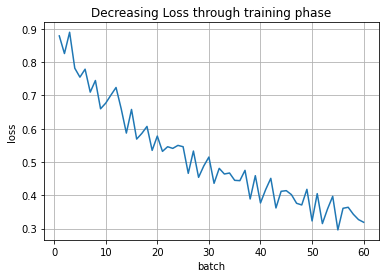

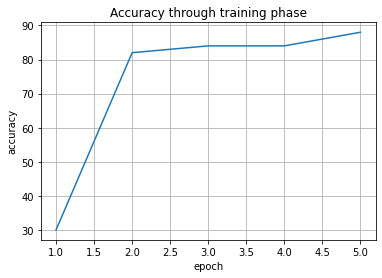

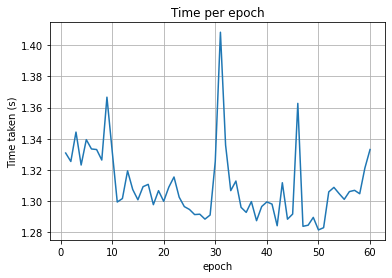

In [12]:
#print(loss_across_epoch)
cnt = np.arange(1, len(loss_across_epoch)+1, 1)

plt.plot( cnt,loss_across_epoch)

plt.xlabel('batch')
plt.ylabel('loss')
plt.title('Decreasing Loss through training phase')
plt.grid(True)
plt.show()

cnt = np.arange(1, len(accuracy_across_epoch)+1, 1)

plt.plot( cnt,accuracy_across_epoch)

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy through training phase')
plt.grid(True)
plt.show()

cnt = np.arange(1, len(time_across_epoch)+1, 1)

plt.plot( cnt,time_across_epoch)

plt.xlabel('epoch')
plt.ylabel('Time taken (s)')
plt.title('Time per epoch')
plt.grid(True)
plt.show()

In [14]:
for n in nn_model_neurons:
    model = Net(n)
    model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)

    optimizer = optim.SGD(model.parameters(), lr=args.lr)
    optimizer = optimizer.fix_precision() 

    for epoch in range(1, args.epochs + 1):
        train(args, model, encrypted_train_loader, optimizer, epoch,False)
        acc_t = test(args, model, encrypted_test_loader,False)
        
    print('\nTraining with {} neurons: Accuracy: {:.0f}%\n'.format(n,acc_t))
    accuracy_nn_model.append(acc_t)


Training with 16 neurons: Accuracy: 68%


Training with 24 neurons: Accuracy: 40%


Training with 32 neurons: Accuracy: 52%


Training with 48 neurons: Accuracy: 96%


Training with 64 neurons: Accuracy: 88%


Training with 84 neurons: Accuracy: 92%



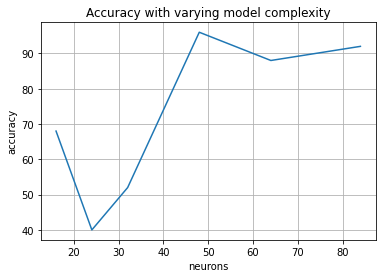

In [15]:
plt.plot( nn_model_neurons,accuracy_nn_model)

plt.xlabel('neurons')
plt.ylabel('accuracy')
plt.title('Accuracy with varying model complexity')
plt.grid(True)
plt.show()

We are getting over 90% accuracy using encrypted training data.

In [13]:
#Save metadata
with open('wine-enc-time', 'wb') as fp:
    pickle.dump(time_across_epoch, fp)
    
with open('wine-enc-acc', 'wb') as fp:
    pickle.dump(accuracy_across_epoch, fp)
    

In [17]:
with open('wine-enc-comp', 'wb') as fp:
    pickle.dump(accuracy_nn_model, fp)